In [1]:
import pandas as pd
import nrrd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 
from scipy.signal import correlate2d

In [2]:
def read_lung_cancer_data(
    excel_path='/kaggle/input/lung-cancer/AI Project 2024-2025-20241230T231658Z-001/AI Project 2024-2025/dataset_lung.xlsx',
    images_dir='/kaggle/input/lung-cancer/AI Project 2024-2025-20241230T231658Z-001/AI Project 2024-2025/Train'
):
    # Load the Excel file
    data = pd.read_excel(excel_path)
    
    # List to store all samples
    dataset = []

    # Iterate through the rows of the Excel file
    for _, row in data.iterrows():
        full_slice_path = os.path.join(images_dir, row['Full_slice'])
        nodule_path = os.path.join(images_dir, row['Nodule'])
        label = row['TumorClass']
        
        # Read the .nrrd files
        full_slice_data, _ = nrrd.read(full_slice_path)
        nodule_data, _ = nrrd.read(nodule_path)
        
        # Append the structured data
        dataset.append({
            'full_slice': full_slice_data,
            'nodule': nodule_data,
            'label': label
        })
    
    return dataset

In [3]:
# Read the lung cancer data
dataset = read_lung_cancer_data(
    excel_path = "../../data/dataset_lung.xlsx",
    images_dir = "../../data/train"
)

# Normalize the images in the dataset
for sample in dataset:
    sample['full_slice'] = (sample['full_slice'] - np.min(sample['full_slice'])) / (np.max(sample['full_slice']) - np.min(sample['full_slice']))
    sample['nodule'] = (sample['nodule'] - np.min(sample['nodule'])) / (np.max(sample['nodule']) - np.min(sample['nodule']))

C:\Users\camil\AppData\Local\Temp\ipykernel_27908\3357748702.py:9: RuntimeWarning: overflow encountered in scalar subtract
  sample['full_slice'] = (sample['full_slice'] - np.min(sample['full_slice'])) / (np.max(sample['full_slice']) - np.min(sample['full_slice']))


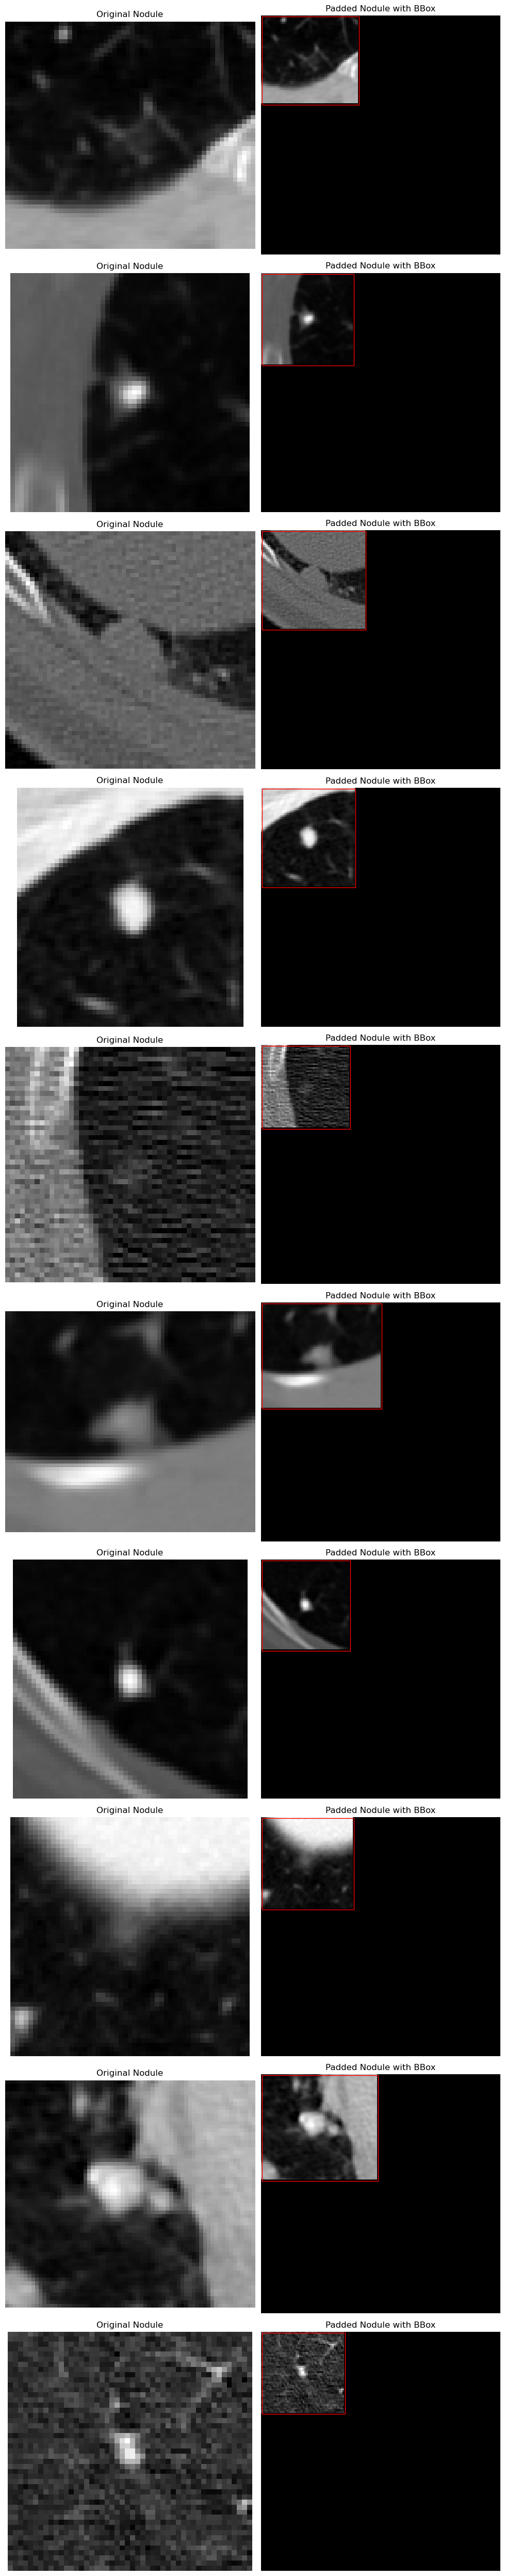

In [5]:
def pad_image(image, target_shape=(138, 138)):
    """
    Pads an image to the target shape with black borders while keeping the original image
    in the top-left corner. Returns the padded image along with the bounding box.
    """
    current_rows, current_cols = image.shape
    
    # Calculate padding for the bottom and right sides
    pad_bottom = target_shape[0] - current_rows
    pad_right = target_shape[1] - current_cols
    
    # Pad the image (top-left corner remains untouched)
    padded_image = np.pad(image, ((0, pad_bottom), (0, pad_right)), mode='constant', constant_values=0)
    
    # Bounding box coordinates (top-left corner with original image dimensions)
    bbox = (0, 0, current_rows, current_cols)  # (top, left, height, width)
    
    return padded_image, bbox

# Plot the images and bounding boxes
fig, axes = plt.subplots(10, 2, figsize=(10, 50))

random_samples = np.random.choice(dataset, 10)

for i, sample in enumerate(random_samples):
    original_nodule = sample['nodule']
    padded_nodule, bbox = pad_image(original_nodule)
    
    # Plot original nodule
    axes[i, 0].imshow(original_nodule, cmap='gray')
    axes[i, 0].set_title('Original Nodule')
    axes[i, 0].axis('off')
    
    # Plot padded nodule with bounding box
    axes[i, 1].imshow(padded_nodule, cmap='gray')
    # Add the rectangle using bbox coordinates
    rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], 
                          edgecolor='red', facecolor='none')
    axes[i, 1].add_patch(rect)
    axes[i, 1].set_title('Padded Nodule with BBox')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


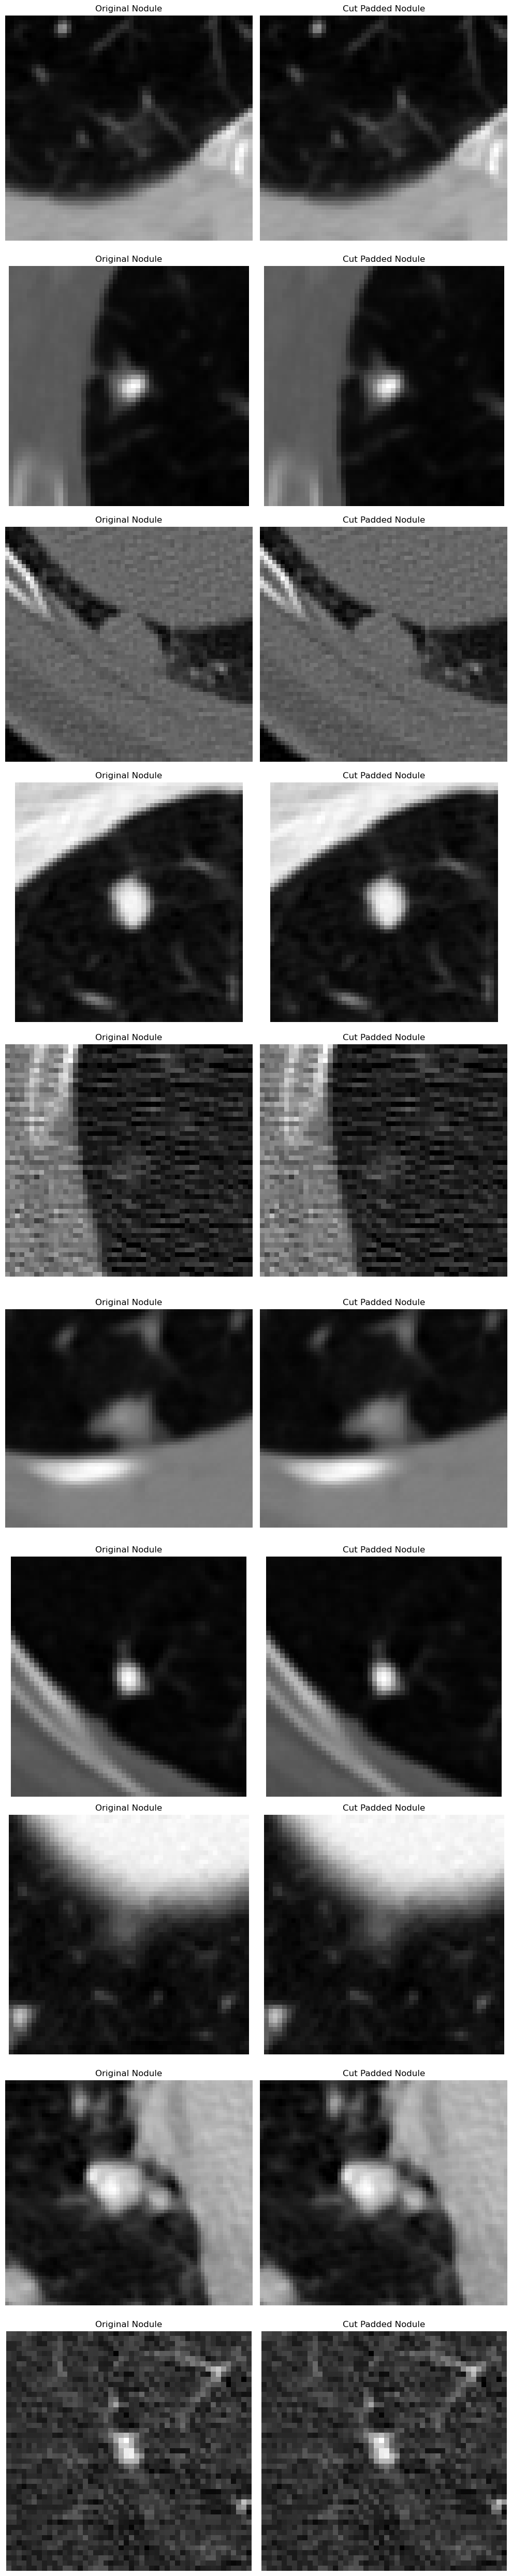

In [6]:
# Plot the images and bounding boxes
fig, axes = plt.subplots(10, 2, figsize=(10, 50))

for i, sample in enumerate(random_samples):
    original_nodule = sample['nodule']
    padded_nodule, bbox = pad_image(original_nodule)
    
    # Extract the cut of the padded image following bbox
    cut_padded_nodule = padded_nodule[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]]
    
    # Plot original nodule
    axes[i, 0].imshow(original_nodule, cmap='gray')
    axes[i, 0].set_title('Original Nodule')
    axes[i, 0].axis('off')
    
    # Plot cut of the padded nodule
    axes[i, 1].imshow(cut_padded_nodule, cmap='gray')
    axes[i, 1].set_title('Cut Padded Nodule')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Extract the required data
full_slices = [sample['full_slice'] for sample in dataset]
padded_nodules = [pad_image(sample['nodule'])[0] for sample in dataset]
bboxes = [pad_image(sample['nodule'])[1] for sample in dataset]
labels = [sample['label'] for sample in dataset]

# Save the data in a compressed .npz file
np.savez_compressed('lung_cancer_padded_bbox.npz', full_slices=full_slices, nodules=padded_nodules, bboxes=bboxes, tumor_classes=labels)